# RAG関連手法の学習 - 2. Routing
* https://python.langchain.com/docs/concepts/#retrieval

In [2]:
from dotenv import load_dotenv
import os
from PIL import Image
# 環境変数読み込み
load_dotenv()

# 画像表示関数
def show_image(path):
    im = Image.open(path)
    return im

## 2. Routing (データソースの選択)
* 質問文に合わせて、動的にデータソースを選択する2津の手法

1. Logical routing
    * LLMを用いてどのdatastoreが最もふさわしいかを判断する手法
    * https://python.langchain.com/docs/how_to/routing/
2. Semantic routing
    * 意味的な類似度でふさわしいdatastoreを選択する手法
    * https://python.langchain.com/docs/how_to/routing/#routing-by-semantic-similarity

### 2-1. Logical routing

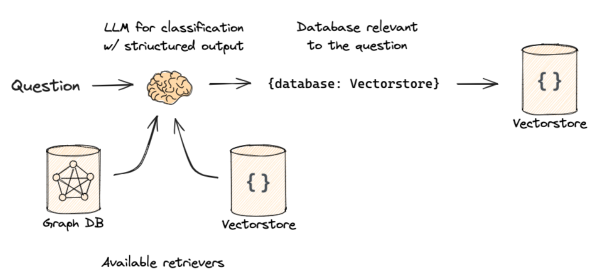

In [2]:
im = show_image("./data/Logical_routing.png")
im

In [3]:
from typing import Literal # 決められた値のみ受付用

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field # 入力データ検証用
from langchain_openai import ChatOpenAI

# Data model
class RouteQuery(BaseModel):
    """Rote a user query to the most relevant datasources."""

    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

### LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm = llm.with_structured_output(RouteQuery)
# with_structured_output()により、LLMの出力がRouteQueryの定義に則って出てくる

# Prompt
system = """You are an expert at routing a user question to the 
appropriate data source. Based on the programming lannguage the question 
is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)

# Define router
router = prompt | structured_llm



/Users/user/miniconda3/envs/rag/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


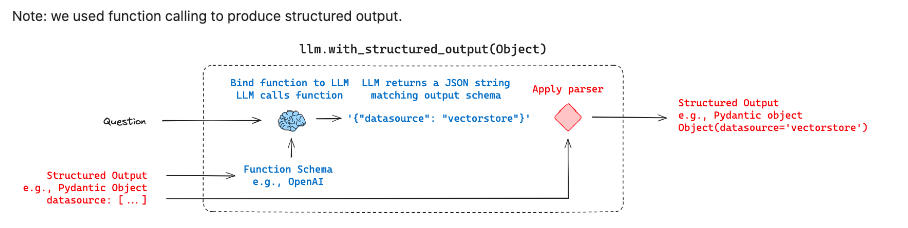

In [4]:
im = show_image("./data/route_2.png")
im

In [5]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})

result

/Users/user/miniconda3/envs/rag/lib/python3.11/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


RouteQuery(datasource='python_docs')

Failed to batch ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/batch. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/batch', '{"detail":"Invalid token"}')
post: trace=f67f2451-e932-43ff-9e63-9745349222c1,id=f67f2451-e932-43ff-9e63-9745349222c1; trace=f67f2451-e932-43ff-9e63-9745349222c1,id=2c4c6075-d1a2-4c0f-917f-60b429a7425b; trace=f67f2451-e932-43ff-9e63-9745349222c1,id=0e1fbd4b-80c9-4037-a29a-69032a72bf93


Failed to batch ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/batch. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/batch', '{"detail":"Invalid token"}')
post: trace=f67f2451-e932-43ff-9e63-9745349222c1,id=1fb47cab-39c7-4788-bbdd-aa4a58bd56a4; patch: trace=f67f2451-e932-43ff-9e63-9745349222c1,id=f67f2451-e932-43ff-9e63-9745349222c1; trace=f67f2451-e932-43ff-9e63-9745349222c1,id=0e1fbd4b-80c9-4037-a29a-69032a72bf93
Failed to batch ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/batch. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/batch', '{"detail":"Invalid token"}')
post: trace=2b0ff2b5-be5c-408c-95f8-f210dd88526d,id=2b0ff2b5-be5c-408c-95f8-f210dd88526d; trace=2b0ff2b5-be5c-408c-95f8-f210dd88526d,id=d6b3529c-45e4-4287-93dc-4b172ad41ae3; trace=2b0ff2b5-be5c-408c-95f8-f210dd8852

In [6]:
result.datasource

'python_docs'

Once we have this, it is trivial to define a branch that uses `result.datasource`

In [9]:
type(result)

__main__.RouteQuery

In [10]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here
        return "chain for js_docs"
    else:
        ### Logic here
        return "galang_docs"
    
from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)

In [11]:
full_chain.invoke({"question": question})

'chain for python_docs'

### 2-2. Semantic routing

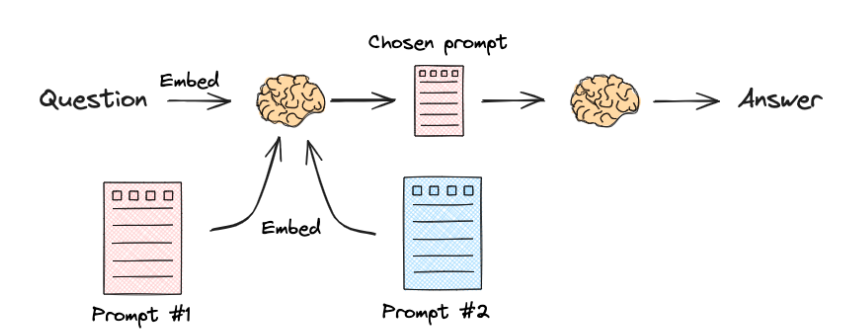

In [12]:
im = show_image("./data/route_3.png")
im

In [23]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Two prompt
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

# Embed prompts
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)


# Route question to prompt
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Computer Similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    # -> 類似度：[0.1669281  0.12770572]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOpenAI()
    | StrOutputParser()
)

ans = chain.invoke("What's a black hole")
print(ans)

Using PHYSICS
A black hole is a region in space where the gravitational pull is so strong that nothing, not even light, can escape from it. This happens when a massive star collapses in on itself, creating a singularity with infinite density at its center. Black holes can vary in size, with the smallest ones being just a few times the mass of our sun, while the largest ones can be millions or even billions of times more massive. They have a boundary called the event horizon, beyond which nothing can escape its gravitational pull.


In [24]:
def print_text(response):
    sentence = ""
    for r in response:
        sentence += r
        if r == ".":
            print(sentence)
            sentence = ""

print_text(ans)

A black hole is a region in space where the gravitational pull is so strong that nothing, not even light, can escape from it.
 This happens when a massive star collapses in on itself, creating a singularity with infinite density at its center.
 Black holes can vary in size, with the smallest ones being just a few times the mass of our sun, while the largest ones can be millions or even billions of times more massive.
 They have a boundary called the event horizon, beyond which nothing can escape its gravitational pull.
